In [1]:
# current dir
%pwd

%cd '~/privacy_active_learning'

/Users/andreasopsahlferstad/privacy_active_learning


In [2]:
import alsDataManager
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm
from matplotlib import rc


In [9]:
no_ts_path = 'final_experiments/ads_xgboost/ads_xgboost_r20_no_ts.txt.txt'
ts_path = 'final_experiments/ads_xgboost/ads_xgboost_r20_t100_1000.txt.txt'

no_ts = alsDataManager.open_dict_from_json(no_ts_path)['results']
ts = alsDataManager.open_dict_from_json(ts_path)['results']

In [10]:
# create df that merges ts and no_ts
d = no_ts

keys1 = list(d.keys())  # assumed to be learning methods
keys2 = list(d[keys1[0]].keys())  # assumed to be row variation
keys3 = list(d[keys1[0]][keys2[0]].keys())  # assumed to be column variation
keys4 = list(d[keys1[0]][keys2[0]][keys3[0]].keys())  # assumed to be performance metrics

methods_no_ts = list(no_ts.keys())


# remove methods_ts here if you have too many
methods_ts = list(ts['learning_method_similar_uncertainty_optimization'].keys())

metrics = ['accuracy', 'consistencies']

df = {}

for metric in metrics:
    df[metric] = {}
    for method in methods_no_ts:
        df[metric][method] = no_ts[method][keys2[0]][keys3[0]][metric]
    for method in methods_ts:
        df[metric][method] = ts['learning_method_similar_uncertainty_optimization'][method][keys3[0]][metric]

In [11]:
def define_color_dict(exclusion_thresholds, upper_color = 1):

    # create color_dict
    n_cmap_lines = 2 + len(methods_ts) - len(exclusion_thresholds)
    cm_subsection = np.linspace(0, upper_color, n_cmap_lines)

    colors = [cm.winter(x) for x in cm_subsection]

    color_dict = {
        'learning_method_random': (0.33, 0.33, 0.33, 1)
    }
    label_dict = {
        'random': 'random',
        'uncertainty': 'uncertainty, k=1',
        'similar': 'similar, k=∞'
    }

    color_dict['learning_method_uncertainty'] = colors[0]
    color_dict['learning_method_similar'] = colors[-1]

    i = 0
    for method in methods_ts:
        label = '_'.join(method.split('_')[2:])
        if label in exclusion_thresholds:
            continue
        color_dict[method] = colors[i+1]
        k = method.split('_')[-1]
        label_dict['_'.join(method.split('_')[2:])] = 'thresholding, k=' + k
        i += 1
    
    return color_dict, label_dict


In [12]:
exclusion_thresholds = []
color_dict, label_dict = define_color_dict(exclusion_thresholds)

In [13]:
df['accuracy'].keys()

dict_keys(['learning_method_random', 'learning_method_similar', 'learning_method_uncertainty', 'certainty_ratio_threshold_100', 'certainty_ratio_threshold_1000'])

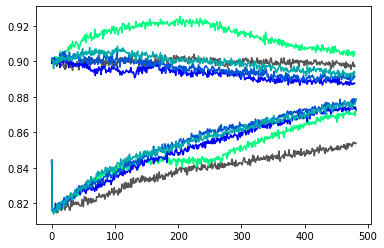

In [14]:
for metric in ['accuracy','consistencies']:
    for method in df[metric]:
        plt.plot(df[metric][method], color=color_dict[method])

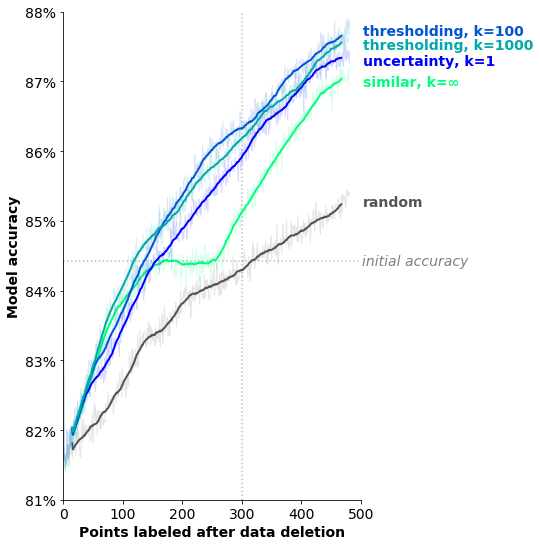

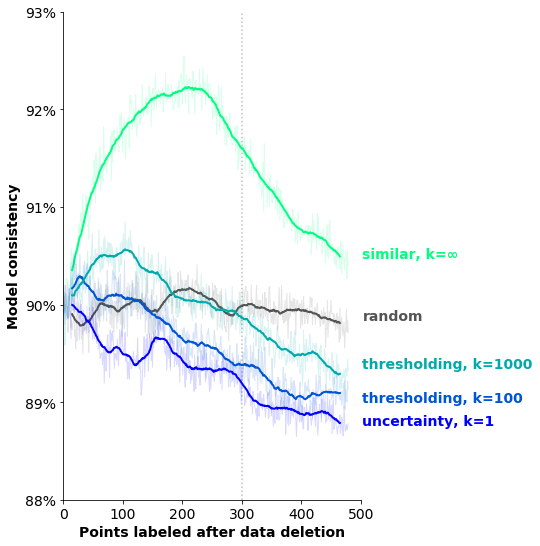

In [32]:
# xg voice 
def plot_ac(save_path, N_DELETED, rolling_window_size, max_x, max_y, min_y, tick_distance_dict, exclusion_thresholds, y_pos_change):
    for metric in metrics:
        width = 3* 2.54
        height = 3* 2.54
        fig = plt.figure(figsize=(width, height))

        # Remove the plot frame lines
        ax = plt.subplot(111)  
        ax.spines["top"].set_visible(False)  
        #ax.spines["bottom"].set_visible(False)  
        ax.spines["right"].set_visible(False)  
        #ax.spines["left"].set_visible(False)  

        # Ensure that the axis ticks only show up on the bottom and left of the plot.  
        # Ticks on the right and top of the plot are generally unnecessary chartjunk.  
        #ax.get_xaxis().tick_bottom()  
        #ax.get_yaxis().tick_left()

        #plt.ylim(min_y, max_y)  

        # Make sure your axis ticks are large enough to be easily read.  
        # You don't want your viewers squinting to read your plot.  

        label = 'points deleted'   
        plt.axvline(x=N_DELETED,
                    color='gray',
                    alpha=0.5,
                    label=label,
                    linestyle='dotted')
        #min_y = ax.get_ylim()[0]
        #max_y = ax.get_ylim()[1]


        if metric == 'accuracy':
            initial_y = df[metric][methods_no_ts[0]][0]
            label = 'initial accuracy'
            plt.axhline(y=initial_y,
                          color='gray',
                          alpha=0.5,
                          label=label,
                          linestyle='dotted')

            plt.text(max_x+1, initial_y-0.0005, label, color = 'gray', fontsize=14, fontstyle = 'italic')

        for i, method in enumerate(df[metric]):  
            label = '_'.join(method.split('_')[2:])
            if label in exclusion_thresholds:
                continue
            s = pd.Series(df[metric][method])
            s_smooth = s.rolling(rolling_window_size, center = True).mean()
            plt.plot(s,
                     label=label,
                     lw=1,
                     alpha=0.15,
                     color=color_dict[method])
            plt.plot(list(s_smooth),
                     label=label,
                     lw=lw,
                     alpha=1,
                     color=color_dict[method])
            y_pos = list(s_smooth)[-rolling_window_size]
            
            change = y_pos_change[metric].get(label, 0)
            y_pos += change
            
            
            
            plt.text(max_x+3, y_pos, label_dict[label], color = color_dict[method], fontsize=14, weight = 'bold')



        plt.xlabel('Points labeled after data deletion', fontsize=14, weight = 'bold')


        plt.ylabel('Model ' + metric, fontsize=14, weight = 'bold')
        if metric == 'consistencies':
            plt.ylabel('Model ' + 'consistency', fontsize=14, weight = 'bold')


        plt.xlim(min_x, max_x)
        plt.ylim(min_y[metric], max_y[metric])

        #label ='points deleted = points added'
        #if metric == 'accuracy':
        #    plt.text(N_DELETED+3, max_y-0.002, label, color='gray', fontsize = 14)
        #    pass
        #else:
        #    plt.text(N_DELETED+3, max_y-0.001, label, color='gray', fontsize = 14)
        #    pass
        # manipulate
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
        plt.tight_layout()

        tick_distances = tick_distance_dict[metric]
        ytick_positions = np.array((range(int(min_y[metric] * 100), int(max_y[metric]*100)+1, tick_distances))) / 100

        plt.yticks(ytick_positions, [str(int(x*100)) + "%" for x in ytick_positions], fontsize=14)  

        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start, end+100, 100))
        plt.xticks(fontsize=14)  
        #plt.legend()
        if metric == 'consistencies':
            plt.savefig(save_path + '_c', dpi = 200)
        else:
            plt.savefig(save_path + '_a', dpi = 200)
                        
save_path = 'ads_xgboost'
N_DELETED = 300
rolling_window_size = 30
lw = 2
max_x = 500
min_x = 0

max_y = dict(zip(metrics, [0.88, 0.93]))
min_y = dict(zip(metrics, [0.81, 0.88]))

tick_distance_dict = {
    'consistencies' : 1,
    'accuracy' : 1
}


y_pos_change = {
    'accuracy' : {
        'random': 0.001,
        'similar': 0.00,
        'uncertainty': -0.0005,
        'threshold_1000': 0.00,
        'threshold_100': +0.001
    },
    'consistencies' : {
        'uncertainty': -0.001,
        'threshold_100': -0.001,
        'similar': -0.001,
    }
}

#exclusion_thresholds = ['threshold_5', 'threshold_50', 'threshold_500']
#color_dict, label_dict = define_color_dict(exclusion_thresholds, 0.95)

plot_ac(save_path=save_path,
        N_DELETED=N_DELETED,
        max_x=max_x,
        max_y=max_y,
        min_y=min_y,
        rolling_window_size=rolling_window_size,
        tick_distance_dict=tick_distance_dict,
       exclusion_thresholds = exclusion_thresholds,
       y_pos_change = y_pos_change)